<a href="https://colab.research.google.com/github/Kunxian-Huang/KunxianHuang_EGP-_ode/blob/main/17th_may__classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content/drive/MyDrive/colab/clean_and_contrain_07_May


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/colab/clean_and_contrain_07_May/
%ls

/content/drive/MyDrive/colab/clean_and_contrain_07_May
train/  val/


In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [ ]:
!nvidia-smi

Thu Jun  3 03:44:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |   6360MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
torch.cuda.empty_cache()
# data_dir = '/content/drive/MyDrive/colab/clean_and_contrain_07_May/'   # student 1                        # this is the data set that only have bathurst samples as clean and this is the data set that have max 60% acc
# data_dir = '/content/drive/MyDrive/colab/bathurst_DUST_included_2_class/'    # student 2                  # this data set has cleaner bathurst images in clean data set and DUST included in contaminated data set
data_dir = '/content/drive/MyDrive/colab/MULITI_INCLUDED_DUST_BATHURST/'       # multi class data set                # this is the dataset that have bathurst and after_skirt as clean samples and DUST is included in contaminated classes


In [ ]:
train_batch=32
val_batch=8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,244)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,244)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_sets=datasets.ImageFolder(os.path.join(data_dir,'train'),data_transforms['train'])
val_sets=datasets.ImageFolder(os.path.join(data_dir,'val'),data_transforms['val'])
train_loader=torch.utils.data.DataLoader(train_sets,batch_size=train_batch,shuffle=True,num_workers=2)
val_loader=torch.utils.data.DataLoader(val_sets,batch_size=val_batch,shuffle=True,num_workers=2)
train_set_size=len(train_sets)
val_set_size=len(val_sets)
names=train_sets.classes
print(train_set_size)
print(val_set_size)
print(names)

1118
558
['CLEAN', 'DUST', 'MBLS', 'MLKS', 'MSTN', 'PCS']


<class 'torch.Tensor'>
tensor([0, 4, 4, 1, 5, 4, 4, 2, 4, 5, 1, 2, 0, 2, 2, 3, 4, 1, 1, 5, 5, 2, 5, 3,
        4, 1, 0, 4, 4, 5, 4, 1])


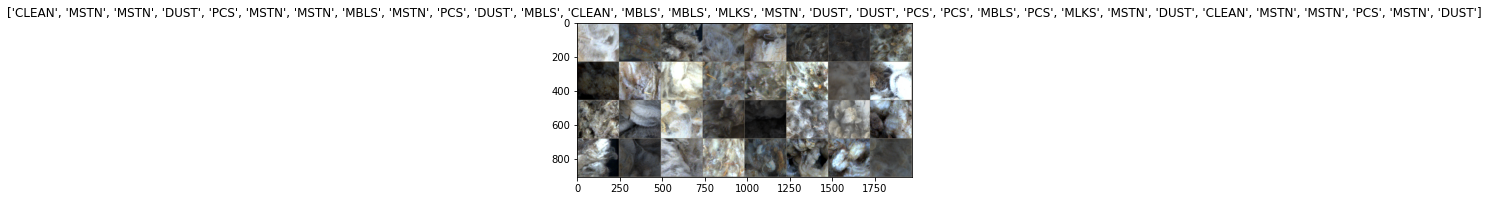

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs2,class2=next(iter(train_loader))
print(type(inputs2[0]))
print(class2)
out2 = torchvision.utils.make_grid(inputs2)
imshow(out2, title=[names[x] for x in class2])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_class,num_epochs=25): 
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_loss_hist=[]
    tr_acc_hist=[]
    val_loss_hist=[]
    val_acc_hist=[]
    class_acc_hist=[]
    best=[]
    in_correct_list=[]
    for i in range(num_class):
      in_correct_list.append([])

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      model.train()
      running_loss=0.0
      running_corrects=0
      for inputs , labels in train_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs=model(inputs)
          _,preds=torch.max(outputs, 1) 
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
        running_loss+=loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / train_set_size
      epoch_acc = running_corrects.double() / train_set_size
      print('train Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
      tr_acc_hist.append(epoch_acc)
      tr_loss_hist.append(epoch_loss)
      scheduler.step()

      
      
      model.eval()
      val_running_loss=0.0
      val_running_corrects=0
      with torch.no_grad():
        total_in_class=np.zeros(num_class)
        class_corrects=np.zeros(num_class)
        class_accuracy=np.zeros(num_class)

        for val_inputs, val_labels in val_loader:
          val_inputs=val_inputs.to(device)
          val_labels=val_labels.to(device)
          for clas in val_labels:
            total_in_class[clas]+=1
          optimizer.zero_grad()
          val_outputs=model(val_inputs)
          _ , val_preds=torch.max(val_outputs,1)
          

          for i in range(len(val_preds)):
            this_class=None
            this_class=val_labels[i]
            if val_preds[i] == val_labels[i] and epoch>19: 
              class_corrects[this_class]+=1
            else:
              in_correct_list[val_labels[i].cpu().numpy()].append(val_preds[i].cpu().numpy())

              if names[this_class] == 'PCS' and epoch >19:  # detial inspection of certain class after network been trained certain number of epochs
                out1=val_inputs[i].cpu()
                out2 = torchvision.utils.make_grid(out1)
                decribe='Ground Truth '+ names[this_class]+ " Predition "+names[val_preds[i]]
                imshow(out2, title=decribe)

          val_loss=criterion(val_outputs,val_labels)
          val_running_loss+=val_loss.item()*val_inputs.size(0)
          val_running_corrects+=torch.sum(val_preds == val_labels)
        val_ep_loss=val_running_loss/val_set_size
        val_ep_acc=val_running_corrects.double() / val_set_size
        if val_ep_acc > best_acc:
          best_acc=val_ep_acc
          best=[epoch,best_acc]
          best_model_wts = copy.deepcopy(model.state_dict())

      for i in range(len(total_in_class)):
        class_accuracy[i]=class_corrects[i]/total_in_class[i]
      class_acc_hist.append(class_accuracy)
      print('Val Loss: {:.4f} Acc: {:.4f}'.format( val_ep_loss, val_ep_acc))
      print()

      val_acc_hist.append(val_ep_acc)
      val_loss_hist.append(val_ep_loss)
 
    time_elapsed = time.time() - since
    average_class_acc=np.mean(class_acc_hist,axis=0)
    # print('per hist is {}'.format(class_acc_hist))
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('average per acc is {}'.format(average_class_acc))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, tr_loss_hist, tr_acc_hist,val_loss_hist,val_acc_hist,best,time_elapsed,average_class_acc,in_correct_list

In [ ]:
def initi_model(model_name,num_classes,feature_extract,pretrain=True):
  model_ft=None
  optimizer_ft=None
  learning_rate=0.001
  if model_name=='resnet18':
    model_ft=models.resnet18(pretrained=pretrain)
    set_parameter_requires_grad(model_ft,feature_extract )
    num_ftrs_re = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs_re, num_classes)
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
  elif model_name=='alex_net':
    model_ft = models.alexnet(pretrained=True)
    set_parameter_requires_grad(model_ft,feature_extract)
    model_ft.classifier[6].in_features
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    model_ft=model_ft.to(device)
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
    print(model_ft)
    for name,param in model_ft.named_parameters():
      if param.requires_grad == True:
        print("\t",name)

  elif model_name=='vgg16':
    model_ft = models.vgg16(pretrained=True)
    set_parameter_requires_grad(model_ft,feature_extract )
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
    for name,param in model_ft.named_parameters():
      if param.requires_grad == True:
        print("\t",name)
  elif model_name=='squeezenet':

    model_ft = models.squeezenet1_0(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
    for name,param in model_ft.named_parameters():
      if param.requires_grad == True:
        print("\t",name)
  
  elif model_name=='densenet':
    model_ft = models.densenet121(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
    for name,param in model_ft.named_parameters():
      if param.requires_grad == True:
        print("\t",name)
  else:
    print('LOL Invalid model name LOL')
  return model_ft , optimizer_ft







# model_name='vgg16'
model_name='densenet'
# model_name='squeezenet'
# model_name='alex_net'
# model_name='resnet18'
num_classes=len(names)
feature_extract=False
epochs=25

model_ft , optimizer_ft = initi_model(model_name,num_classes,feature_extract,pretrain=True)
# print(model_ft)
model_ft=model_ft.to(device)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)






	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.denseblock1.densela

Epoch 0/24
----------
train Loss: 1.6458 Acc: 0.3184
Val Loss: 1.2603 Acc: 0.5753

Epoch 1/24
----------
train Loss: 1.0696 Acc: 0.6878
Val Loss: 0.6863 Acc: 0.8280

Epoch 2/24
----------
train Loss: 0.6554 Acc: 0.7916
Val Loss: 0.4568 Acc: 0.8871

Epoch 3/24
----------
train Loss: 0.4552 Acc: 0.8596
Val Loss: 0.4352 Acc: 0.8495

Epoch 4/24
----------
train Loss: 0.3603 Acc: 0.8819
Val Loss: 0.3857 Acc: 0.8871

Epoch 5/24
----------
train Loss: 0.3112 Acc: 0.9043
Val Loss: 0.3480 Acc: 0.8961

Epoch 6/24
----------
train Loss: 0.2187 Acc: 0.9302
Val Loss: 0.2589 Acc: 0.9247

Epoch 7/24
----------
train Loss: 0.1743 Acc: 0.9580
Val Loss: 0.1896 Acc: 0.9498

Epoch 8/24
----------
train Loss: 0.1564 Acc: 0.9597
Val Loss: 0.1922 Acc: 0.9462

Epoch 9/24
----------
train Loss: 0.1620 Acc: 0.9597
Val Loss: 0.1860 Acc: 0.9480

Epoch 10/24
----------
train Loss: 0.1575 Acc: 0.9580
Val Loss: 0.1840 Acc: 0.9498

Epoch 11/24
----------
train Loss: 0.1345 Acc: 0.9732
Val Loss: 0.1881 Acc: 0.9480

Ep

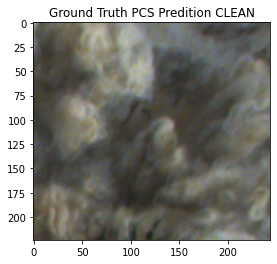

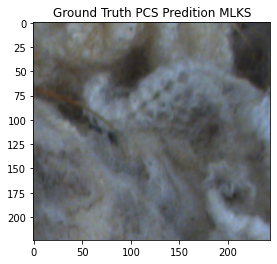

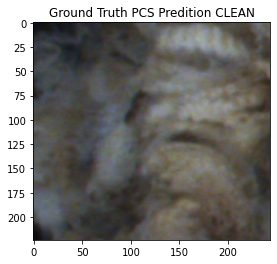

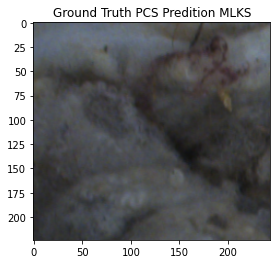

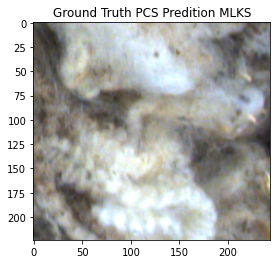

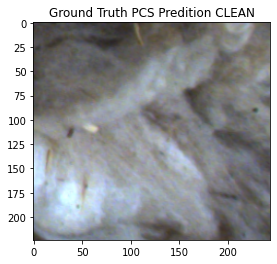

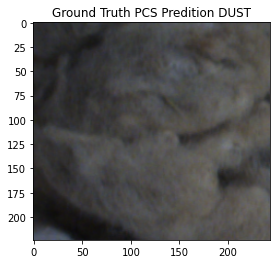

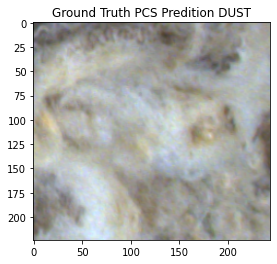

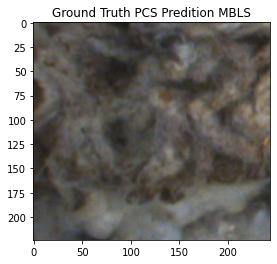

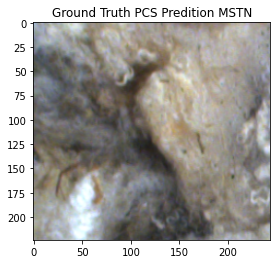

Val Loss: 0.1743 Acc: 0.9534

Epoch 21/24
----------
train Loss: 0.1341 Acc: 0.9687


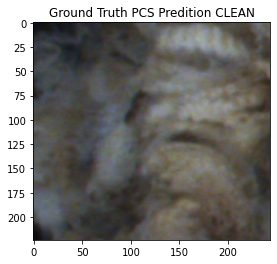

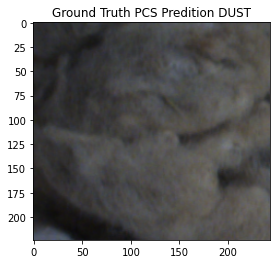

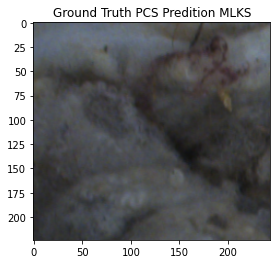

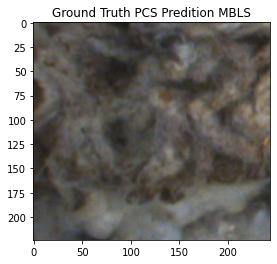

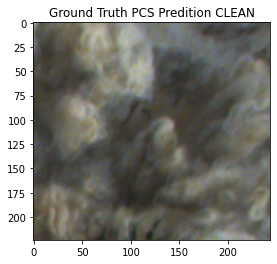

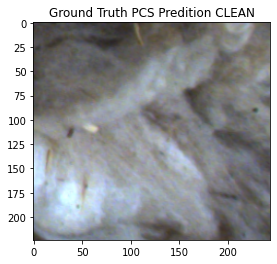

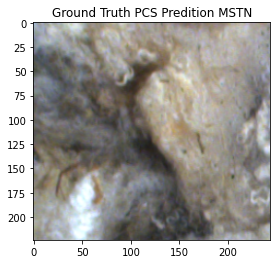

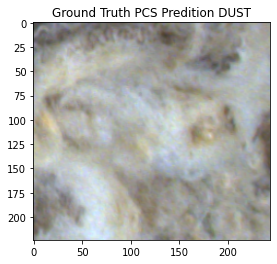

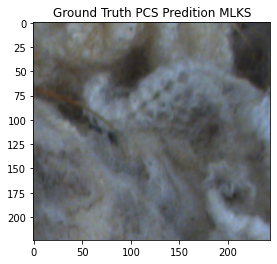

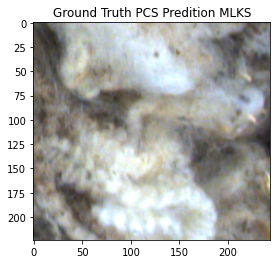

Val Loss: 0.1738 Acc: 0.9534

Epoch 22/24
----------
train Loss: 0.1324 Acc: 0.9714


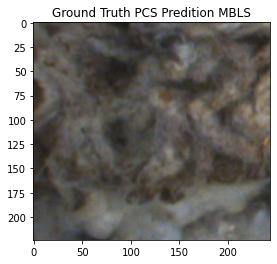

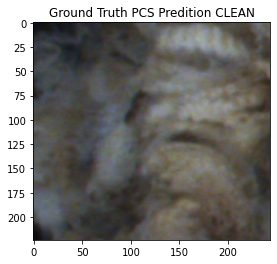

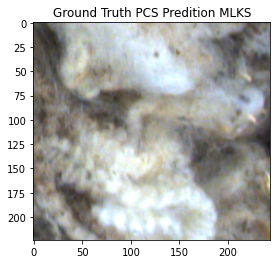

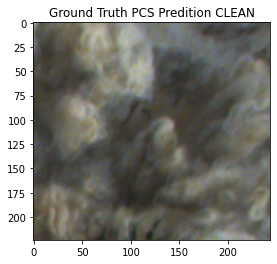

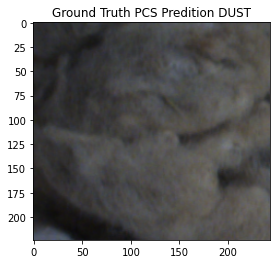

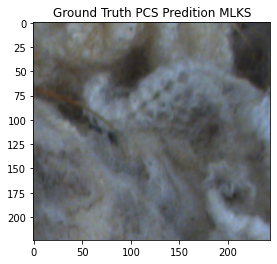

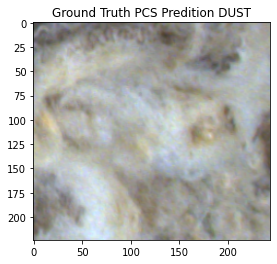

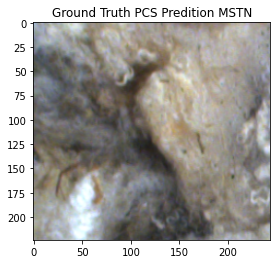

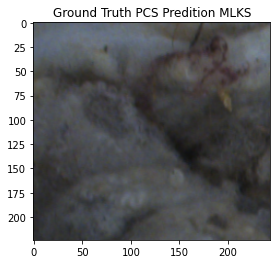

Val Loss: 0.1763 Acc: 0.9534

Epoch 23/24
----------
train Loss: 0.1405 Acc: 0.9669


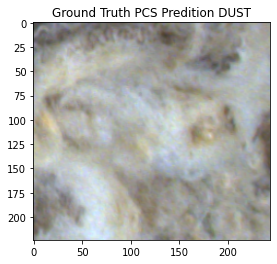

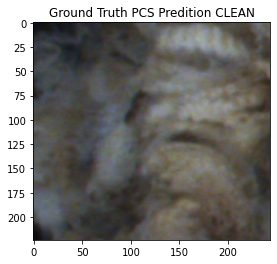

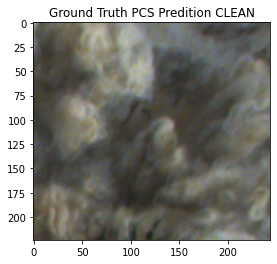

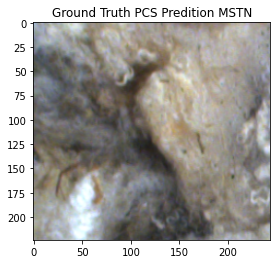

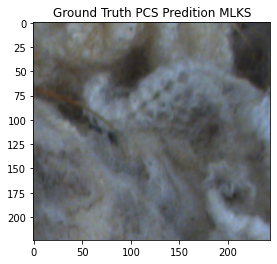

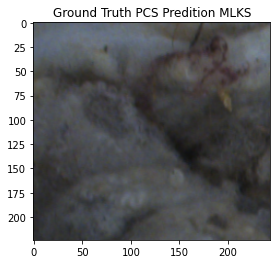

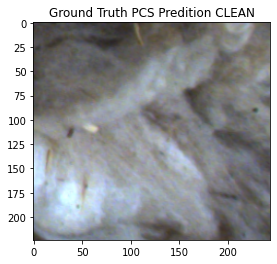

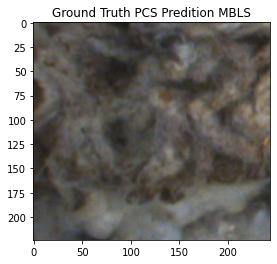

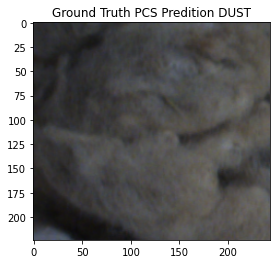

Val Loss: 0.1820 Acc: 0.9516

Epoch 24/24
----------
train Loss: 0.1345 Acc: 0.9651


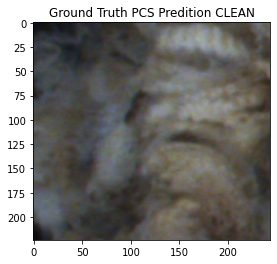

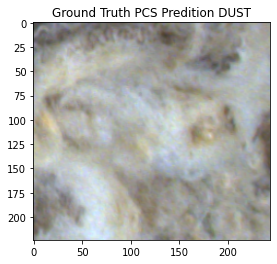

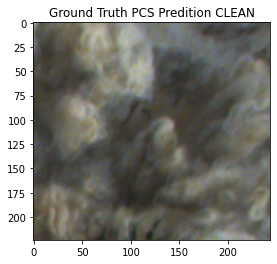

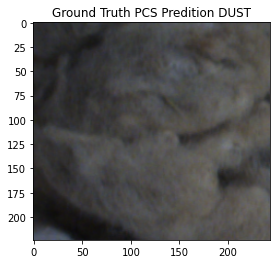

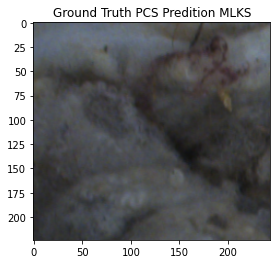

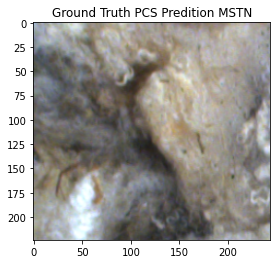

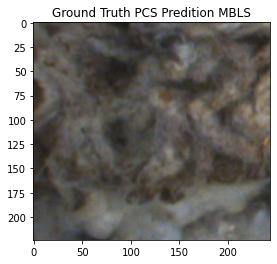

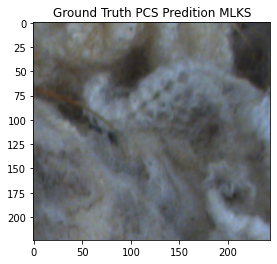

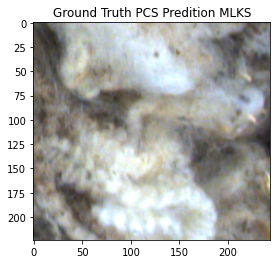

Val Loss: 0.1756 Acc: 0.9444

Training complete in 7m 4s
average per acc is [0.19       0.18581818 0.196      0.2        0.19407407 0.18021053]
Best val Acc: 0.953405


In [ ]:
model,tr_loss_hist , tr_acc_hist,val_loss_hist,val_acc_hist , best, training_time,average_class_acc,in_correct_list=train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler_ft,num_classes, epochs)

Best acc is 0.953405 and training time is 7m 4s
densenet_batch_32
class CLEAN accuracy is 0.190000 
class DUST accuracy is 0.185818 
class MBLS accuracy is 0.196000 
class MLKS accuracy is 0.200000 
class MSTN accuracy is 0.194074 
class PCS accuracy is 0.180211 


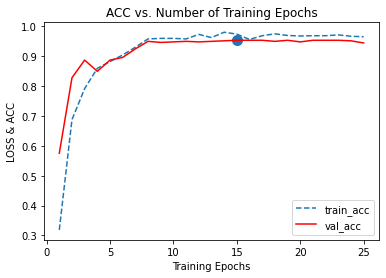

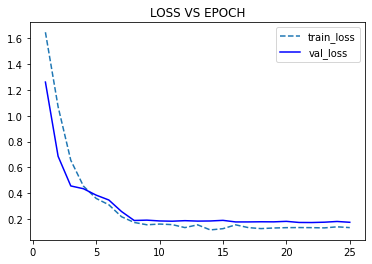

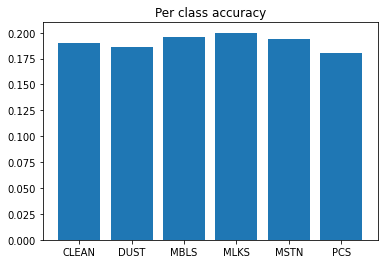

In [ ]:
train_loss_hist=tr_loss_hist
train_acc_hist=[]
train_acc_hist= [i.cpu().numpy() for i in tr_acc_hist]
val_acc_hist1=[]
val_acc_hist1 = [h.cpu().numpy() for h in val_acc_hist]
val_loss_hist1=val_loss_hist


plt.title("ACC vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("LOSS & ACC")
plt.plot(range(1,epochs+1),train_acc_hist,'--',label="train_acc")
plt.plot(range(1,epochs+1),val_acc_hist1,'r',label="val_acc")
plt.scatter(best[0]+1,best[1].cpu(),s=100)
plt.legend(loc='best')
# plt.show()


fig2,ax2=plt.subplots()
ax2.plot(range(1,epochs+1),train_loss_hist,'--',label="train_loss")
ax2.plot(range(1,epochs+1),val_loss_hist1,'b',label="val_loss")
ax2.set_title('LOSS VS EPOCH')
ax2.legend(loc='best')



data=average_class_acc
fig, ax = plt.subplots()
ax.bar(names,data)
ax.set_title('Per class accuracy')

print('Best acc is {:4f} and training time is {:.0f}m {:.0f}s'.format(best[1],training_time//60,training_time % 60))
# print()
# print('MODEL: {}  transfer learning: {}'.format(model_name,feature_extract))
# print()
# print(data_dir)
# print()
# print('training batching size is {} and validation batch size is {}'.format(train_batch,val_batch))
# print()
print('{}_batch_{}'.format(model_name,train_batch))
# print()
data=average_class_acc
for i in range(len(names)):
  print('class {} accuracy is {:4f} '.format(names[i],data[i]))

6
CLEAN
[1.817e+03 1.610e+02 9.000e+00 1.000e+00 1.000e+00 3.600e+01]
DUST
[ 120. 2036.    3.    0.    7.   73.]
MBLS
[   9.   44. 1664.    0.   72.   20.]
MLKS
[   0.   53.    0. 1025.   17.    5.]
MSTN
[   0.   10.   75.   29. 2035.   27.]
PCS
[  77.  111.   24.   81.   74. 1580.]


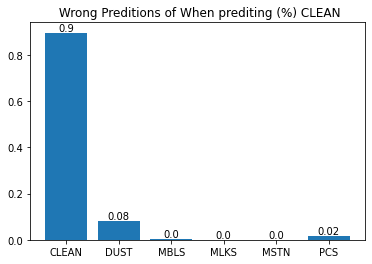

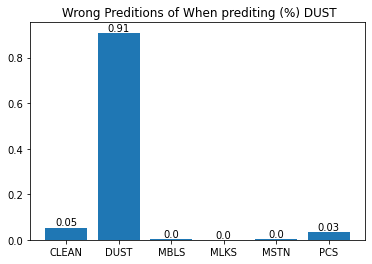

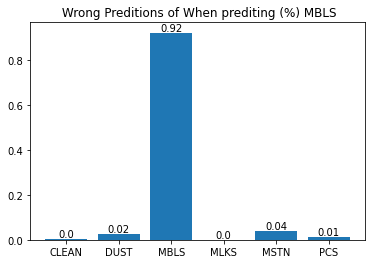

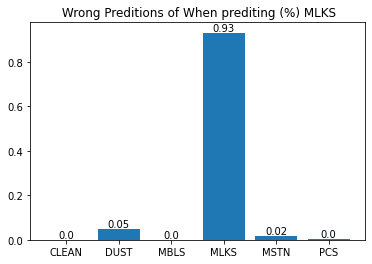

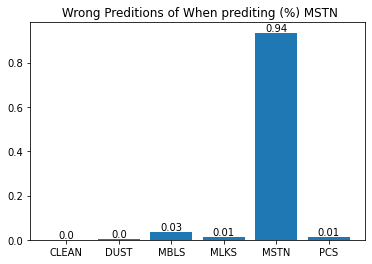

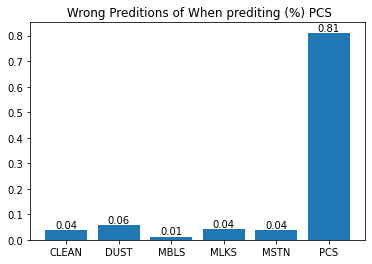

In [ ]:
# print(names)
count=0
axs=[]
for i in range(len(names)):
  _,axn=plt.subplots()
  axs.append(axn)
print(len(axs))



for i in in_correct_list:
  print(names[count])
  
  in_corrects_labels=np.zeros(len(names))
  
  for in_correct_label in i:
    if in_correct_label==0:
      in_corrects_labels[0]+=1

    elif in_correct_label ==1:
      in_corrects_labels[1]+=1

    elif in_correct_label ==2:
      in_corrects_labels[2]+=1

    elif in_correct_label ==3:
      in_corrects_labels[3]+=1

    elif in_correct_label ==4:
      in_corrects_labels[4]+=1

    elif in_correct_label ==5:
      in_corrects_labels[5]+=1



  print(in_corrects_labels)
  # print(sum(in_corrects_labels))
  
  data=[]
  data=in_corrects_labels/sum(in_corrects_labels).round(2)
  # print(data)

  axs[count].bar(names,data)
  axs[count].set_title(' Wrong Preditions of When prediting (%) '+names[count])
  for i in range(len(names)):
	  axs[count].annotate(str(data[i].round(2)),xy=(names[i],data[i]),ha='center',va='bottom')
  count+=1



  # axs[count].bar(names,in_corrects_labels)
  # axs[count].set_title(' Wrong Preditions of '+names[count])
  # for i in range(len(names)):
	#   axs[count].annotate(str(in_corrects_labels[i]),xy=(names[i],in_corrects_labels[i]),ha='center',va='bottom')
  # count+=1


  
